# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Знакомство с данными - загрузим данные и изучим с чем нам предстоит работать

Предоброботка - исправим ошибки которые будут в данных 

Подготовке данных - подготовим данные для машинного обучения

Обучим модели 
* LinearRegression
* CatBoostRegressor
* LGBMRegressor 
* DecisionTreeRegressor
* RandomForestRegressor       

И найдем среди них самую лучшую модель по точности и скорости предсказания

## Знакомство с данными

In [1]:
!pip install scikit-learn==1.1.3
!pip install phik

Загрузим библиотеки

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import phik
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn.preprocessing._encoders')


from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from phik.report import plot_correlation_matrix
from phik import report

RANDOM_STATE = 333

Загрузим и сохраним данные в датафрейм **df**

In [3]:
df = pd.read_csv('autos.csv')

Выведем первые 5 строк датафрейма

In [4]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


* **DateCrawled** — дата скачивания анкеты из базы
* **VehicleType** — тип автомобильного кузова
* **RegistrationYear** — год регистрации автомобиля
* **Gearbox** — тип коробки передач
* **Power** — мощность (л. с.)
* **Model** — модель автомобиля
* **Kilometer** — пробег (км)
* **RegistrationMonth** — месяц регистрации автомобиля
* **FuelType** — тип топлива
* **Brand** — марка автомобиля
* **NotRepaired** — была машина в ремонте или нет
* **DateCreated** — дата создания анкеты
* **NumberOfPictures** — количество фотографий автомобиля
* **PostalCode** — почтовый индекс владельца анкеты (пользователя)
* **LastSeen** — дата последней активности пользователя

Выведем информацию о нашем датафрейме

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Проверим на дубликаты

In [7]:
df.duplicated().sum()

4

* Можно привести столбцы к стилю snake_case
* Заметим пропущенные значен
* Заметим что все значения в столбце NumberOfPictures принимают нулевые значения
* Можно изменить типы данных в таблице и удалить не нужные колонки
* Так же в наших данных присутствуют 4 явных дубликата

Посмотрим на распределение наших данных

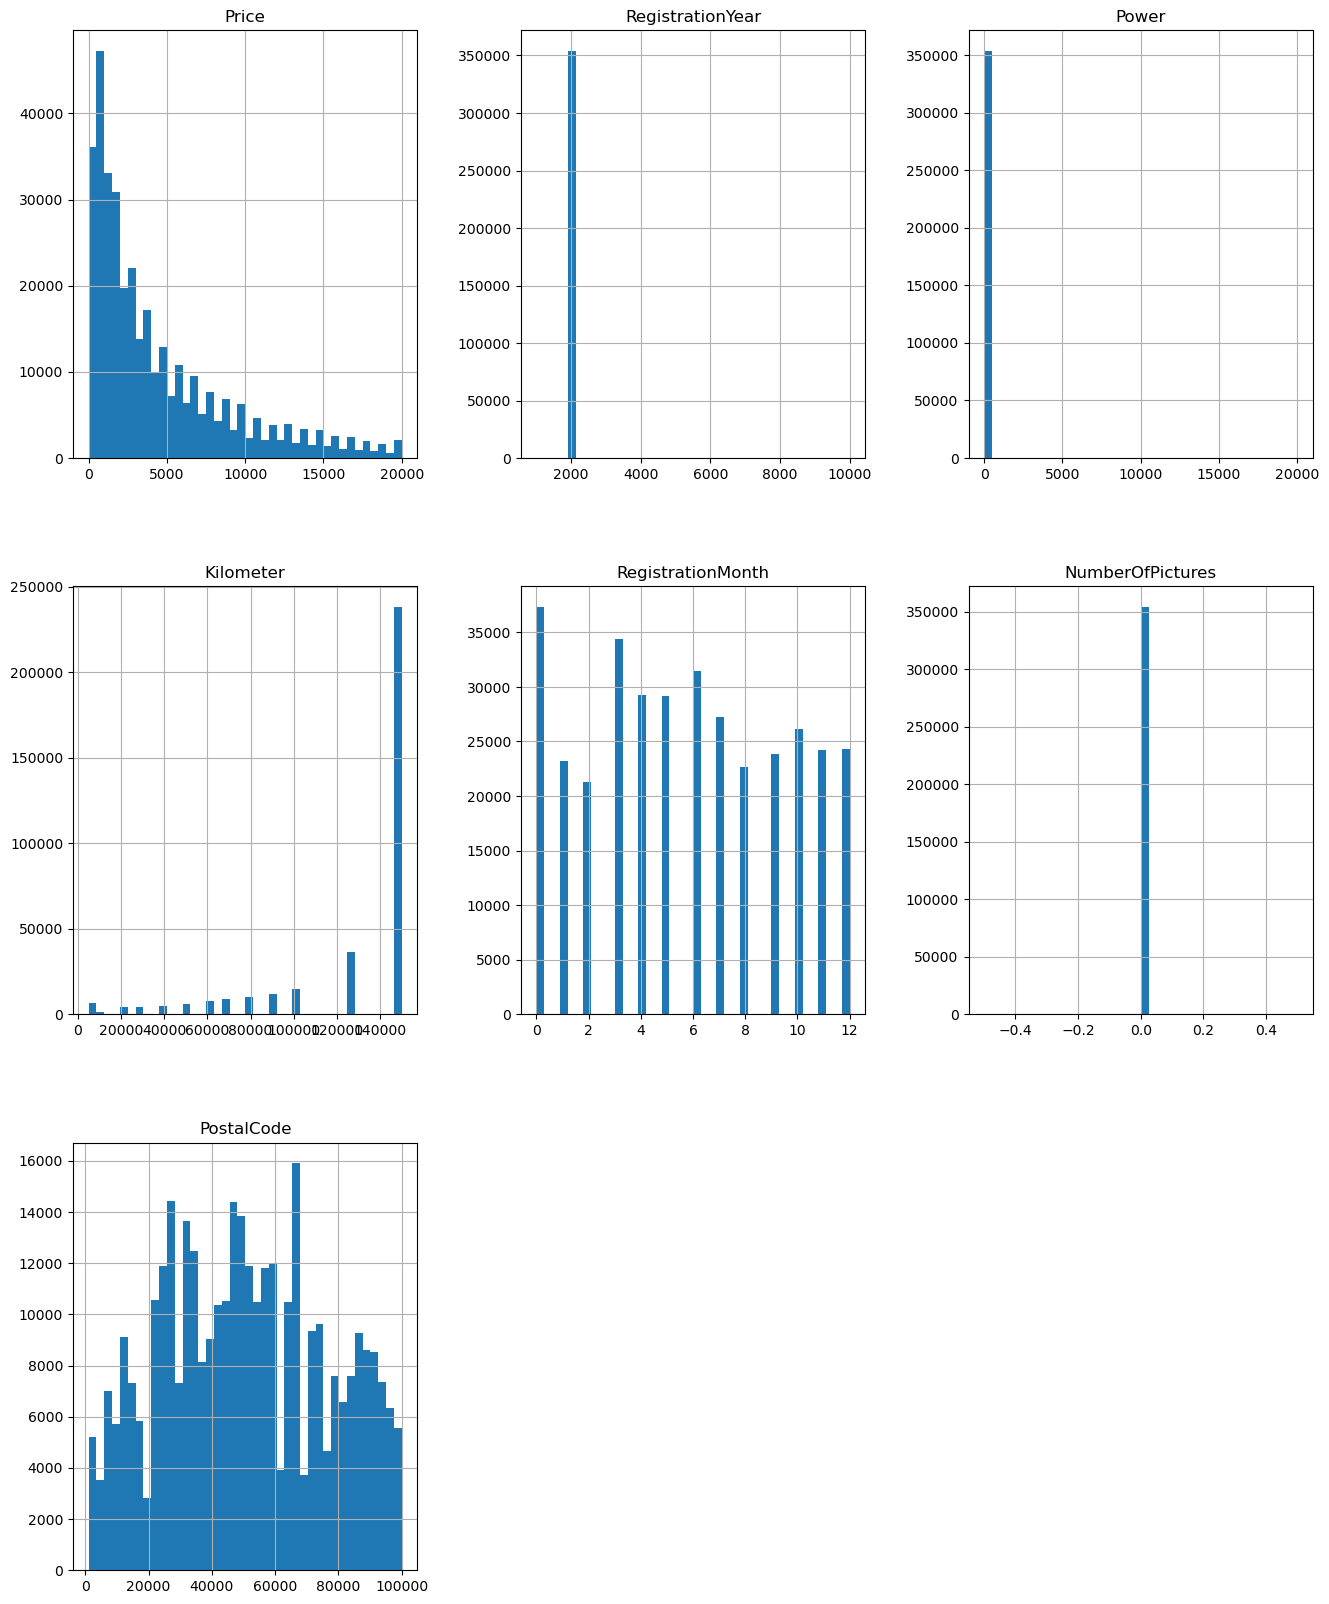

In [8]:
df.hist(bins=40, figsize=(16,20));

### Вывод по знакомству с данными
* Мы загрузили нужные нам библиотеки и данные
* Сохранили данные в датафрейм **df**
* Выяснили, что:
    * Нужно привести столбцы к стилю snake_case
    * В наших данных есть пропущенные значен
    * Все значения в столбце NumberOfPictures принимают нулевые значения
    * Нужно изменить типы данных в таблице и удалить не нужные колонки
    * В данных присутствуют 4 явных дубликата

## Предобработка

### Переименуем столбцы

Посмотрим на названия столбцов в нашей таблице

In [9]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Приведем названия столбцов к стилю snake_case

In [10]:
df.columns = ['date_crawled','price', 'vehicle_type', 'registration_year', 'gearbox',
              'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
              'repaired', 'date_created', 'number_of_pictures', 'postal_code',
              'last_seen']

Проверим названия столбцов

In [11]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Названия столбцов были успешно изменены 

### Удалим дубликаты

# Явные дубликаты

Посмотрим на количество явных дубликатов

In [12]:
df.duplicated().sum()

4

Всего было найдено 4 явных дубликата избавимся от них

In [13]:
df = df.drop_duplicates().reset_index(drop=True)

Явные дубликаты были удаленны, проверим данные на неявные дубликаты

#### Неявные дубликаты

Посмотрим дубликаты по столбцам **postal_code**, **date_created**, **brand**, **model**, **registration_year**, **registration_month**, **last_seen**

In [14]:
df.duplicated(subset=['postal_code', 'date_created', 'brand', 'model', 'registration_year', 'registration_month']).sum()

17350

Возможно что владельцы выкладывали свои машины с помощью нескольких аккаунтов, удалим найденные дубликаты 

In [15]:
df = (
    df.drop_duplicates(subset=['postal_code', 'date_created', 'brand',
                               'model', 'registration_year', 'registration_month'])
    .reset_index(drop=True)
)

Мы неявные удалили дубликаты

#### Дубликаты в категориальных столбцах

In [16]:
df.head(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Посмотрим есть ли дубликаты в столбцах **vehicle_type**, **gearbox**, **model**, **fuel_type**, **brand**, **repaired**

In [17]:
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [18]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [19]:
df['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [20]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [21]:
df['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

### Измеим типы данных

Посмотри на типы данных в нашем датафрейме

In [22]:
df.dtypes

date_crawled          object
price                  int64
vehicle_type          object
registration_year      int64
gearbox               object
power                  int64
model                 object
kilometer              int64
registration_month     int64
fuel_type             object
brand                 object
repaired              object
date_created          object
number_of_pictures     int64
postal_code            int64
last_seen             object
dtype: object

Выведем первые 3 строчки нашего датафрейма

In [23]:
df.head(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Выведем информацию о нашем датафрейме

In [24]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,337015.000000,337015.000000,337015.000000,337015.000000,337015.000000,337015.0,337015.000000
mean,4394.000872,2004.253324,109.849057,128250.359776,5.692948,0.0,50526.205590
std,4511.936398,91.862525,190.706530,37931.663822,3.732948,0.0,25826.906957
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1000.000000,1999.000000,68.000000,125000.000000,3.000000,0.0,30159.000000
50%,2700.000000,2003.000000,104.000000,150000.000000,6.000000,0.0,49377.000000
75%,6300.000000,2008.000000,141.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Мы можем изменить:
* **date_crawled**:          object -> datetime
* **price**:                  int64 -> uint16
* **registration_year**:      int64 -> uint16
* **power**:                  int64 -> uint16
* **kilometer**:              int64 -> uint32
* **registration_month**:     int64 -> uint8
* **date_created**:          object -> datetime
* **number_of_pictures**:     int64 -> uint8
* **postal_code**:            int64 -> uint32
* **last_seen**:             object -> datetime

Данные изменения увеличет вычислительную производительность и сэкономит место, посмотрим сколько весит наш датафрейм

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337015 entries, 0 to 337014
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        337015 non-null  object
 1   price               337015 non-null  int64 
 2   vehicle_type        300291 non-null  object
 3   registration_year   337015 non-null  int64 
 4   gearbox             317837 non-null  object
 5   power               337015 non-null  int64 
 6   model               317712 non-null  object
 7   kilometer           337015 non-null  int64 
 8   registration_month  337015 non-null  int64 
 9   fuel_type           304969 non-null  object
 10  brand               337015 non-null  object
 11  repaired            268593 non-null  object
 12  date_created        337015 non-null  object
 13  number_of_pictures  337015 non-null  int64 
 14  postal_code         337015 non-null  int64 
 15  last_seen           337015 non-null  object
dtypes:

Наш датафрейм весит 41.1 MB, перейдем к изменению типов данных

In [26]:
df.date_crawled = pd.to_datetime(df.date_crawled)
df.price = df.price.astype('uint16')
df.registration_year = df.registration_year.astype('uint16')
df.power = df.power.astype('uint16')
df.kilometer = df.kilometer.astype('uint32')
df.registration_month = df.registration_month.astype('uint8')
df.date_created = pd.to_datetime(df.date_created)
df.number_of_pictures = df.number_of_pictures.astype('uint8')
df.postal_code = df.postal_code.astype('uint32')
df.last_seen = pd.to_datetime(df.last_seen)

Посмотрим на типы данных после изменения

In [27]:
df.dtypes

date_crawled          datetime64[ns]
price                         uint16
vehicle_type                  object
registration_year             uint16
gearbox                       object
power                         uint16
model                         object
kilometer                     uint32
registration_month             uint8
fuel_type                     object
brand                         object
repaired                      object
date_created          datetime64[ns]
number_of_pictures             uint8
postal_code                   uint32
last_seen             datetime64[ns]
dtype: object

Все типы данных были успешно изменены, проверим сколько весит наш датафрейм

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337015 entries, 0 to 337014
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        337015 non-null  datetime64[ns]
 1   price               337015 non-null  uint16        
 2   vehicle_type        300291 non-null  object        
 3   registration_year   337015 non-null  uint16        
 4   gearbox             317837 non-null  object        
 5   power               337015 non-null  uint16        
 6   model               317712 non-null  object        
 7   kilometer           337015 non-null  uint32        
 8   registration_month  337015 non-null  uint8         
 9   fuel_type           304969 non-null  object        
 10  brand               337015 non-null  object        
 11  repaired            268593 non-null  object        
 12  date_created        337015 non-null  datetime64[ns]
 13  number_of_pictures  337015 no

До изменения типов наш датафрейм весил 41.1+ MB сейчас 28.3+ MB. Мы успешно изменили типы 

### Работа с пропусками

Посмотри на количество пропускрв в данных

In [29]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          36724
registration_year         0
gearbox               19178
power                     0
model                 19303
kilometer                 0
registration_month        0
fuel_type             32046
brand                     0
repaired              68422
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

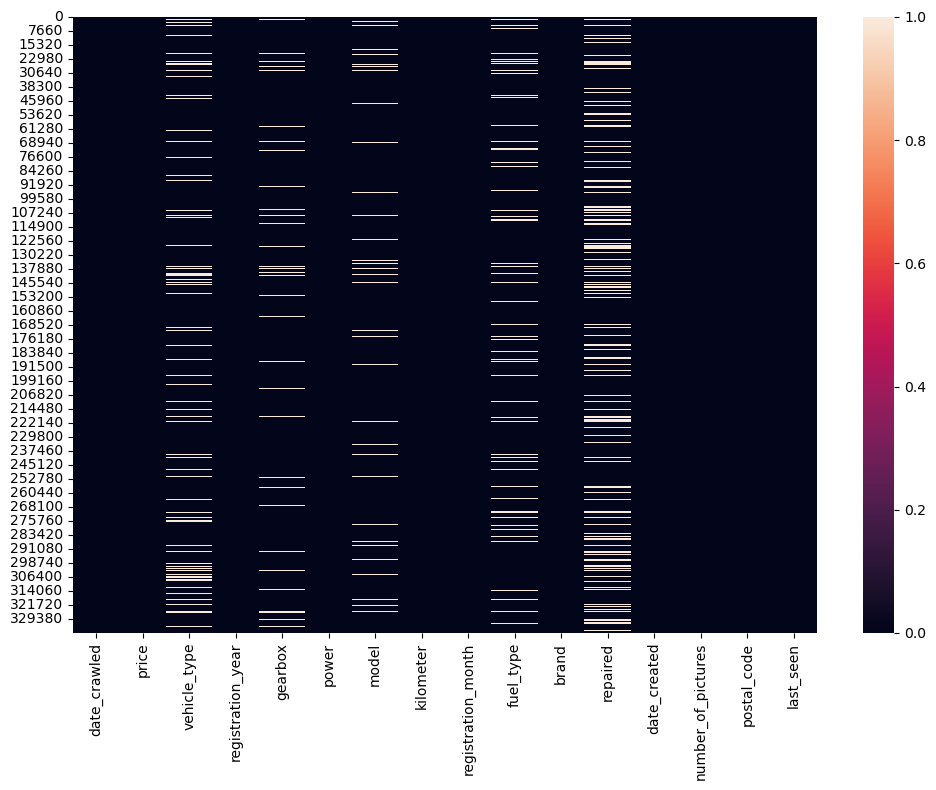

In [30]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isna());

Как мы можем заметить пропуски присутствуют в **vehicle_type**, **gearbox**, **model**, **fuel_type**, **repaired**, разберем пропуски по столбцам

#### Пропуски в model

**model** - это столбец в котором записана модель автомобиля, посмотрим на количество пропусков

In [31]:
df['model'].isna().sum()

19303

Пропуски в этом столбце невозможно востоновить, по этому просто заменим пропущенные значения на *other*

In [32]:
df.loc[df['model'].isna(), 'model'] = 'other'

Выведем количество пропусков в столбце **model**

In [33]:
df['model'].isna().sum()

0

Мы изавились от пропусков в столбце **model** заменив их на *unknown*

#### Пропуски в vehicle_type

**vehicle_type** - это столбец в котором записан тип автомобильного кузова, посмотрим на количество пропусков 

In [34]:
df['vehicle_type'].isna().sum()

36724

Напишем функцию для заполнения пропусков в **vehicle_type** по бренду и модели машины

In [35]:
def vehicle_type_rec():
    for brand in df['brand'].unique():
        for model in df.loc[df['brand'] == brand,'model'].unique():
            try:
                vehicle = df.loc[(df['model'] == model) & (df['brand'] == brand),'vehicle_type'].value_counts().index[0]
                df.loc[(df['model'] == model) & (df['brand'] == brand) & (df['vehicle_type'].isna()),'vehicle_type'] = vehicle
            except:
                print(brand, model)
    print(df['vehicle_type'].isna().sum())

Применим фукнцию, она выведет количество пропусков в **vehicle_type**

In [36]:
vehicle_type_rec()

0


Мы избавились от пропусков в столбце **vehicle_type**

#### Пропуски в gearbox

**gearbox** - это столбец в котором записан тип коробки передач, посмотрим на количество пропусков 

In [37]:
df['gearbox'].isna().sum()

19178

Напишем функцию для заполнения пропусков в **gearbox**  она будет заполнять самыми популярными значениями по бренду, модели и типу кузова машины. если передать в функцию параметр True, то функция будет выводить параметры с которыми не было найденно самого популярного 

In [38]:
def gearbox_rec(error=False):
    for brand in df['brand'].unique():
        for model in df.loc[df['brand'] == brand,'model'].unique():
            for vehicle in df.loc[(df['brand'] == brand) & (df['model'] == model),'vehicle_type'].unique():
                try:
                    gearbox = df.loc[(df['vehicle_type'] == vehicle) & (df['model'] == model) & (df['brand'] == brand),'gearbox'].value_counts().index[0]
                    df.loc[(df['model'] == model) & (df['brand'] == brand) & (df['gearbox'].isna()) & (df['vehicle_type'] == vehicle), 'gearbox'] = gearbox
                except:
                    if error:
                        print(brand, model, vehicle)
    print(df['gearbox'].isna().sum())

Применим функцию

In [39]:
gearbox_rec()

22


Удалим оставшиеся 30 пропусков

In [40]:
df = df.dropna(subset=['gearbox']).reset_index(drop=True)

Мы избавились от пропусков в столбце gearbox

#### Пропуски в fuel_type

**fuel_type** - это столбец в котором записан тип топлива, посмотрим на количество пропусков.

In [41]:
df['fuel_type'].isna().sum()

32034

Напишем функцию для заполнения пропусков в **fuel_type**  она будет заполнять самыми популярными значениями по бренду, модели и типу кузова машины. если передать в функцию параметр True, то функция будет выводить параметры с которыми не было найденно самого популярного 

In [42]:
def fuel_type_rec(error=False):
    for brand in df['brand'].unique():
        for model in df.loc[df['brand'] == brand,'model'].unique():
            for vehicle in df.loc[(df['brand'] == brand) & (df['model'] == model),'vehicle_type'].unique():
                try:
                    fuel = df.loc[(df['vehicle_type'] == vehicle) & (df['model'] == model) & (df['brand'] == brand),'fuel_type'].value_counts().index[0]
                    df.loc[(df['model'] == model) & (df['brand'] == brand) & (df['fuel_type'].isna()) & (df['vehicle_type'] == vehicle), 'fuel_type'] = fuel
                except:
                    if error:
                        print(brand, model, vehicle)
    print(df['fuel_type'].isna().sum())

Запустим и посмотрим оставшиеся пропуски

In [43]:
fuel_type_rec()

25


Остался 31 пропуск, удалим строки с пропусками

In [44]:
df = df.dropna(subset=['fuel_type']).reset_index(drop=True)

Мы избавились от пропусков в столбце **fuel_type**

#### Пропуски в repaired

Посмотрим на количество пропусков в столбце **repaired**

In [45]:
df['repaired'].isna().sum()

68393

Мы не можем востоновить данные по столбцу **rapaired**, их слишком много чтобы удалить по этому заменим пропуски на *other*, 

In [46]:
df['repaired'].fillna('other', inplace=True)

#### Итоги работы с пропусками

Посмотрим на количество пропусков

In [47]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Как мы видим мы полностью избавились от пропусков:
* **model** - заменили пропуски на *unknown*
* **vehicle_type** - востоновили по признакам **model**, **brand**
* **gearbox** - востоновили по признакам **model**, **brand**, **vehicle_type**
* **fuel_type** - востоновили по признакам **model**, **brand**, **vehicle_type**
* **repaired** - заменили пропуски на *unknown*

### Выбросы в данных

#### Количественные данные 

Посмотрим информацию о количественных переменны 

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336968 entries, 0 to 336967
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        336968 non-null  datetime64[ns]
 1   price               336968 non-null  uint16        
 2   vehicle_type        336968 non-null  object        
 3   registration_year   336968 non-null  uint16        
 4   gearbox             336968 non-null  object        
 5   power               336968 non-null  uint16        
 6   model               336968 non-null  object        
 7   kilometer           336968 non-null  uint32        
 8   registration_month  336968 non-null  uint8         
 9   fuel_type           336968 non-null  object        
 10  brand               336968 non-null  object        
 11  repaired            336968 non-null  object        
 12  date_created        336968 non-null  datetime64[ns]
 13  number_of_pictures  336968 no

In [49]:
def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title("Плотность распределения " + data_label, fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.histplot(data, bins=num_bins, ax=axes[0])
    axes[1].set_title("Boxplot " + data_label, fontsize=18)
    sns.boxplot(data=df, x=data_label, ax=axes[1])
    plt.show()

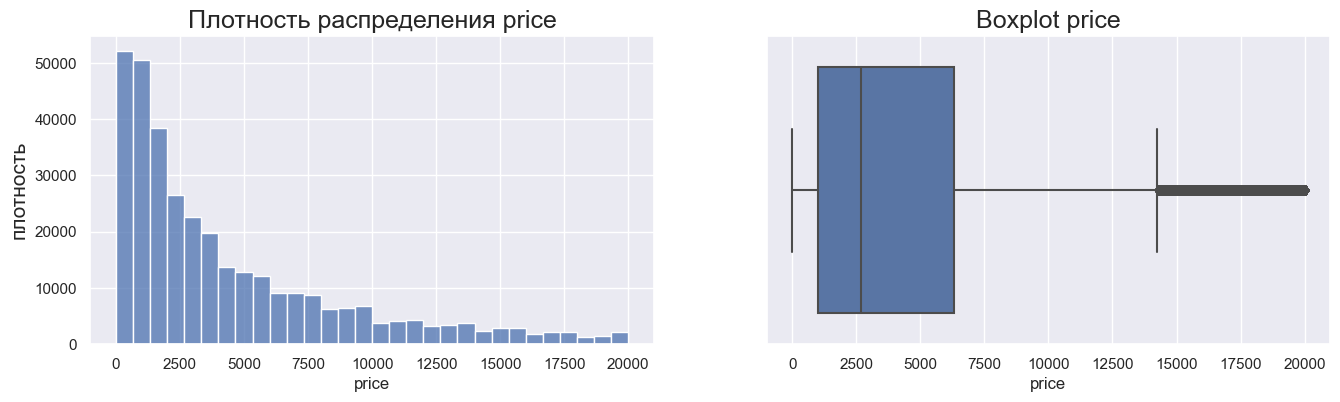

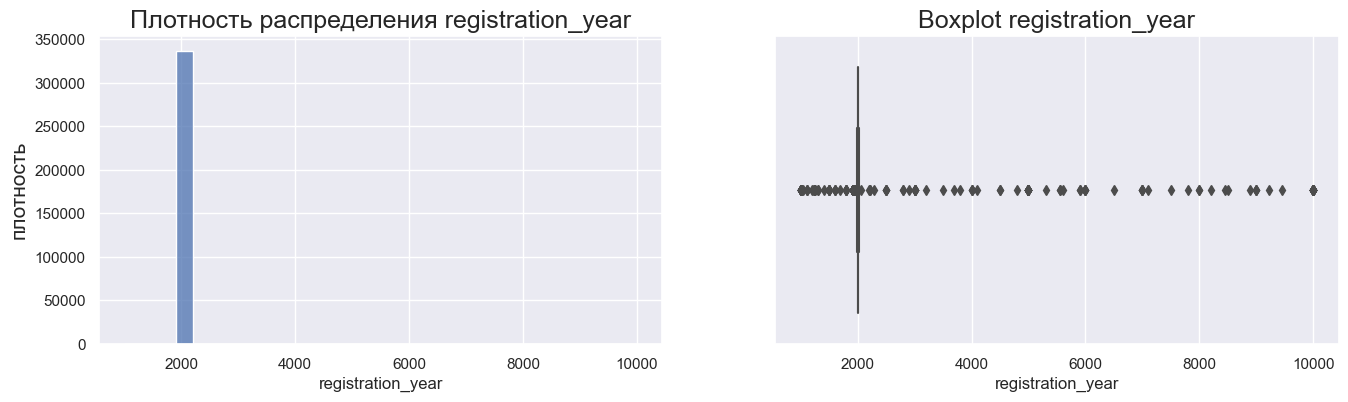

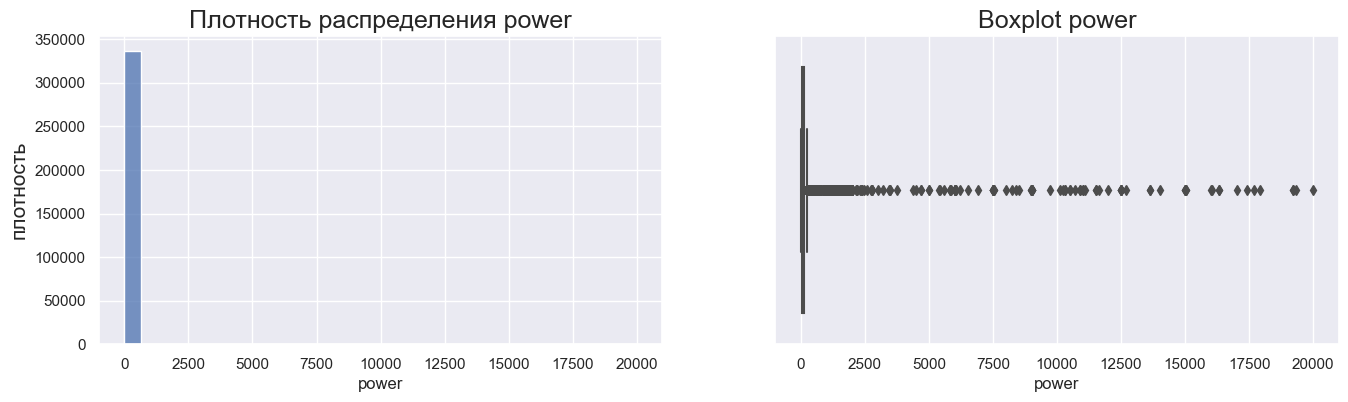

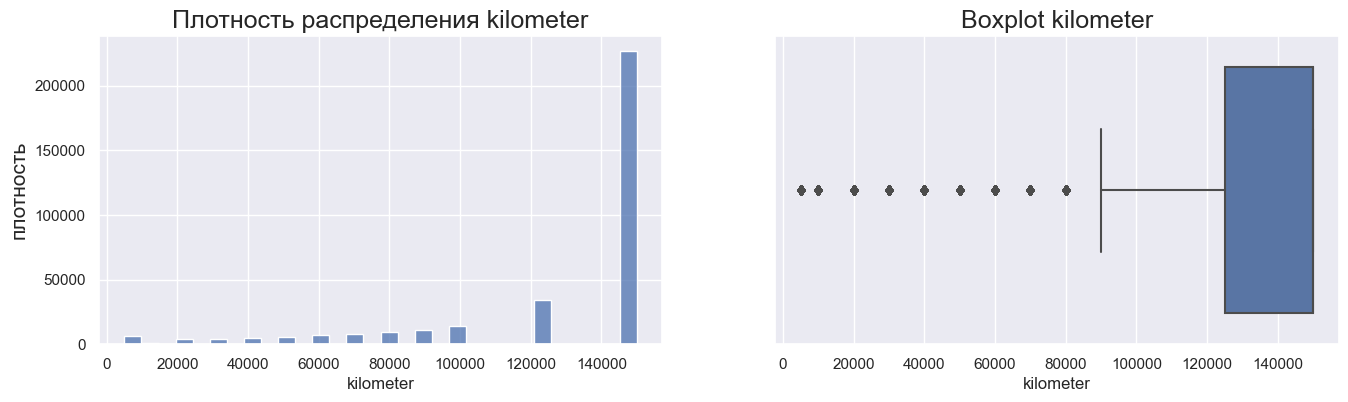

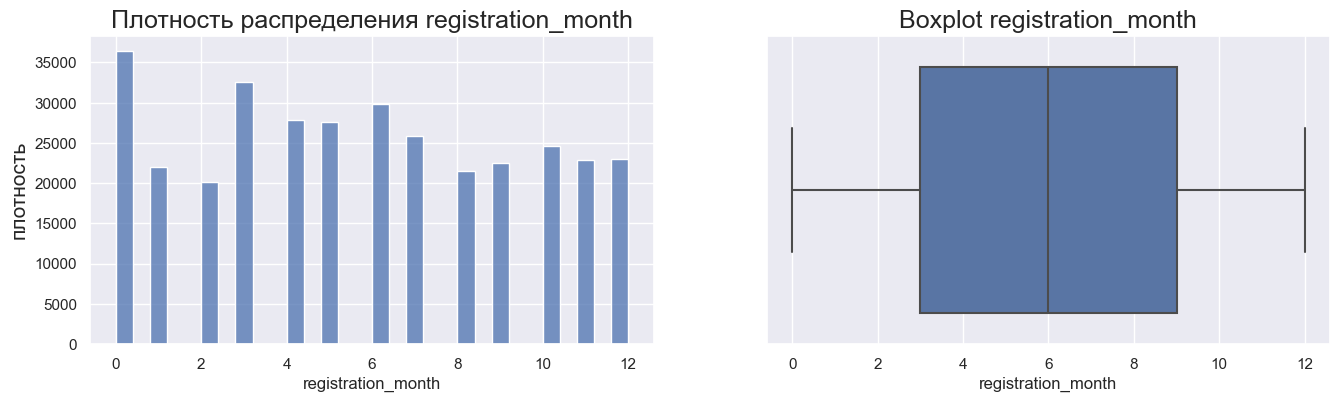

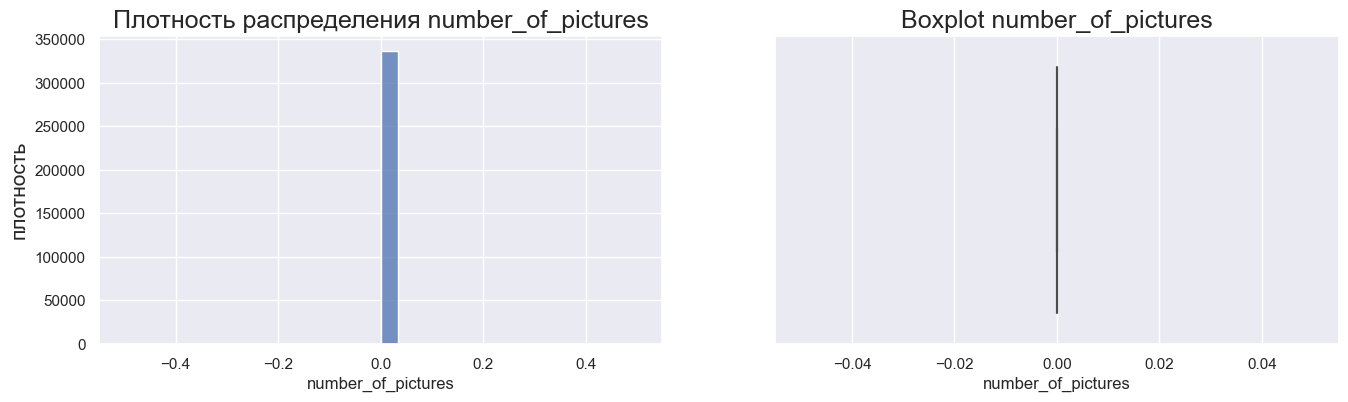

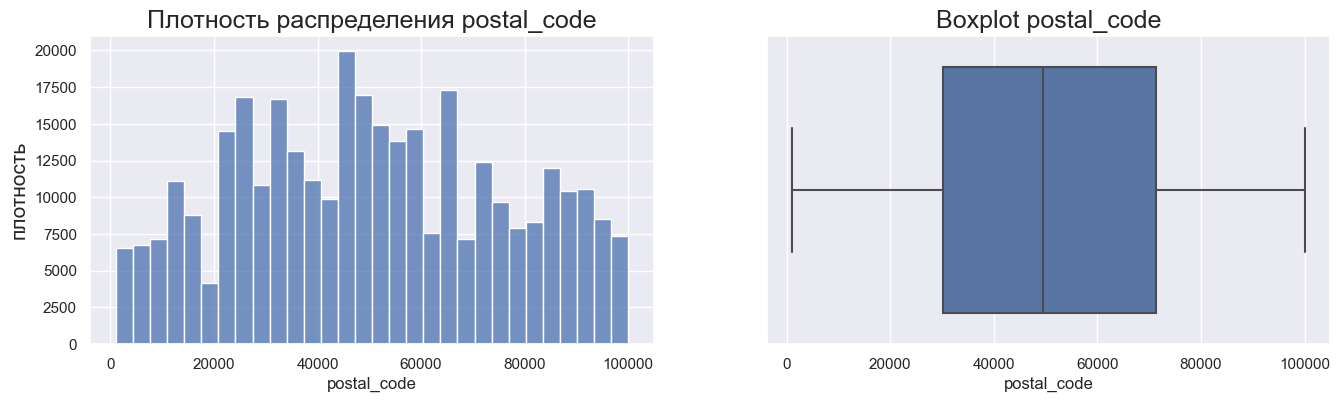

In [50]:
numerics = ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'number_of_pictures', 'postal_code']
for column in numerics:
    show_hists(df[column], column, num_bins=30)

In [51]:
def number_of_emissions(data,col, multiplier=1.5, keep='all', details=False):
    rate_min = 0
    rate_max = 0
    if keep == 'all':
        score_max = (data[col].quantile(0.75) - data[col].quantile(0.25))*multiplier + data[col].quantile(0.75)
        rate_max = round(len(data.loc[data[col] > score_max]) / len(data) * 100, 2)

        score_min = data[col].quantile(0.25) - \
                (data[col].quantile(0.75) - data[col].quantile(0.25))*1.5
        rate_min = round(len(data.loc[data[col] < score_min]) / len(data) * 100, 2)
        
        if details:
            print(f'Параметр: {col}\n'
                 f'Гранницы: {score_min} - {score_max}\n'
                 f'min - max значения: {df[col].min()} - {df[col].max()}\n'
                 f'Доля выбросов: {rate_min} - {rate_max}')
        
        rate = rate_max + rate_min
        print(f'Доля всех выбросов в параметре {col}: {rate}%\n')
        return   
        
        
    if keep == 'lower':
        score_min = data[col].quantile(0.25) - \
                (data[col].quantile(0.75) - data[col].quantile(0.25))*1.5
        rate_min = round(len(data.loc[data[col] < score_min]) / len(data) * 100, 2)
        
        if details:
            print(f'Параметр: {col}\n'
                 f'Гранница: {score_min}\n'
                 f'man: {df[col].max()}')
        print(f'Доля выбросов в параметре {col}: {rate_min}%\n')
        return
        
    if keep == 'higher':
        score_max = (data[col].quantile(0.75) - data[col].quantile(0.25))*multiplier + data[col].quantile(0.75)
        rate_max = round(len(data.loc[data[col] > score_max]) / len(data) * 100, 2)
        
        if details:
            print(f'Параметр: {col}\n'
                 f'Гранница: {score_max}\n'
                 f'man: {df[col].max()}')
        print(f'Доля выбросов в параметре {col}: {rate_max}%\n')
        return
        

In [52]:
for col in numerics:
    number_of_emissions(df,col, details=True)

Параметр: price
Гранницы: -6950.0 - 14250.0
min - max значения: 0 - 20000
Доля выбросов: 0.0 - 5.42
Доля всех выбросов в параметре price: 5.42%

Параметр: registration_year
Гранницы: 1985.5 - 2021.5
min - max значения: 1000 - 9999
Доля выбросов: 1.78 - 0.03
Доля всех выбросов в параметре registration_year: 1.81%

Параметр: power
Гранницы: -41.5 - 250.5
min - max значения: 0 - 20000
Доля выбросов: 0.0 - 2.1
Доля всех выбросов в параметре power: 2.1%

Параметр: kilometer
Гранницы: 87500.0 - 187500.0
min - max значения: 5000 - 150000
Доля выбросов: 14.99 - 0.0
Доля всех выбросов в параметре kilometer: 14.99%

Параметр: registration_month
Гранницы: -6.0 - 18.0
min - max значения: 0 - 12
Доля выбросов: 0.0 - 0.0
Доля всех выбросов в параметре registration_month: 0.0%

Параметр: number_of_pictures
Гранницы: 0.0 - 0.0
min - max значения: 0 - 0
Доля выбросов: 0.0 - 0.0
Доля всех выбросов в параметре number_of_pictures: 0.0%

Параметр: postal_code
Гранницы: -31446.0 - 132834.0
min - max значени

Разберемся с каждым столбцом:
* price - доля выбросов 5.42%
    * Уберем только 0 значения, так как это не правдоподобная цена за машину
* registration_year - доля выбросов 1.81%
    * уберем все значения что не лежать в деапозоне с 1985 по 2022
* power - доля выбросов 1.81%
    * уберем все значения что не лежать в деапозоне с 10 по 1200 л.с.
* kilometer - доля выбросов 14.99%
    * не будем убирать эти значения
* registration_month - доля выбросов 0.0%
    * почему-то насчитывается 13 месяцев, попробуем понять почему
* number_of_pictures - доля выбросов 0.0%
    * Удалим этот столбец в нем нет даннызх
* postal_code - доля выбросов 0.0%
    * Все хорошо

##### Выбросы price

посмотрим сколько значений лежат на разных промежутках

In [53]:
print(f'Кол-во данных со стоимостью 0: {len(df[df["price"] == 0])}')
print(f'Кол-во данных со стоимостью меньше 50: {len(df[df["price"] < 50])}')
print(f'Кол-во данных со стоимостью меньше 100: {len(df[df["price"] < 100])}')
print(f'Кол-во данных со стоимостью меньше 200: {len(df[df["price"] < 200])}')
print(f'Кол-во данных со стоимостью меньше 400: {len(df[df["price"] < 400])}')

Кол-во данных со стоимостью 0: 10415
Кол-во данных со стоимостью меньше 50: 12022
Кол-во данных со стоимостью меньше 100: 12898
Кол-во данных со стоимостью меньше 200: 16973
Кол-во данных со стоимостью меньше 400: 29254


Можно убрать данные о машинах которые стоят меньше 100 евро

In [54]:
df = df[~(df['price'] < 100)]

Мы убрали данные о машинах которые стоят меньше 100 евро

##### Выбросы registration_year

Посмотрим на  дату выгрузки анкет из базы данных

In [55]:
df['date_crawled'].describe([])

count                           324070
mean     2016-03-21 13:07:35.673107200
min                2016-03-05 14:06:24
50%                2016-03-21 17:48:19
max                2016-04-07 14:36:58
Name: date_crawled, dtype: object

Как мы видим крайний год выгрузки анкет 2016, так что посмотрим все какое количество данных не лежат в деапозоне с 1985 по 2016

In [56]:
print(f'Кол-во машин которые не входят в диапозон: {len(df[((df["registration_year"] < 1985) | (df["registration_year"] > 2016))])}')

Кол-во машин которые не входят в диапозон: 18058


Удалим эти данные так как машины до 1985 года слишком старые, а машины год регистрации которых больше 2016 года, не могут существовать так как последние анкеты были выгружены в 2016 году

In [57]:
df = df[~((df["registration_year"] < 1985) | (df["registration_year"] > 2016))]

##### Выбросы power

Посмотри сколько все значения что не лежать в деапозоне с 10 по 1200 л.с.

In [58]:
print(f'Кол-во машин которые не входят в диапозон: {len(df[((df["power"] < 10) | (df["power"] > 1200))])}')

Кол-во машин которые не входят в диапозон: 29721


In [59]:
df = df[~((df["power"] < 10) | (df["power"] > 1200))]

##### Выбросы registration_month

Посмотрим на гистограмму

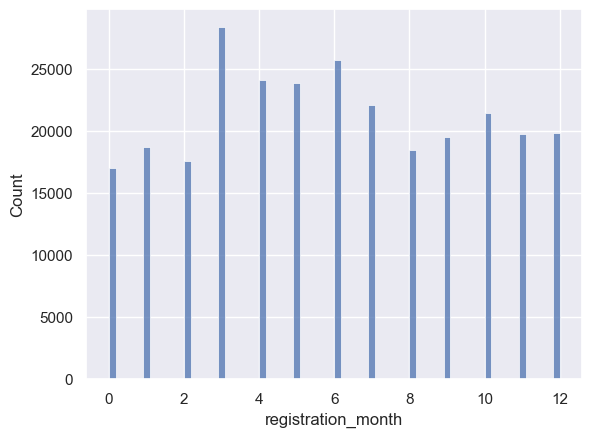

In [60]:
sns.histplot(df['registration_month']);

Как мы видим всего у нас есть данные по 13 месяцам, скорее всего 0 месяц или 12 выставленны по ошибке. Не будем это исправлять, так как это не повлияет сильно на наши модели, но учтем

##### Удалим number_of_pictures

Удалим колонку number_of_pictures, так как все значения в ней это нули

In [61]:
df.drop('number_of_pictures', axis=1, inplace=True)

Мы удалили столбец number_of_pictures

#### Категориальные данные 

In [62]:
def show_hists(data, data_label1, data_label2=''):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label1 + ". CountPlot", fontsize=18)
    sns.countplot(data=data, x=data_label1, ax=axes[0])
    if data_label2 != '':
        axes[1].set_title(data_label2 + ". CountPlot", fontsize=18)
        sns.countplot(data=data, x=data_label2, ax=axes[1])
    plt.show()

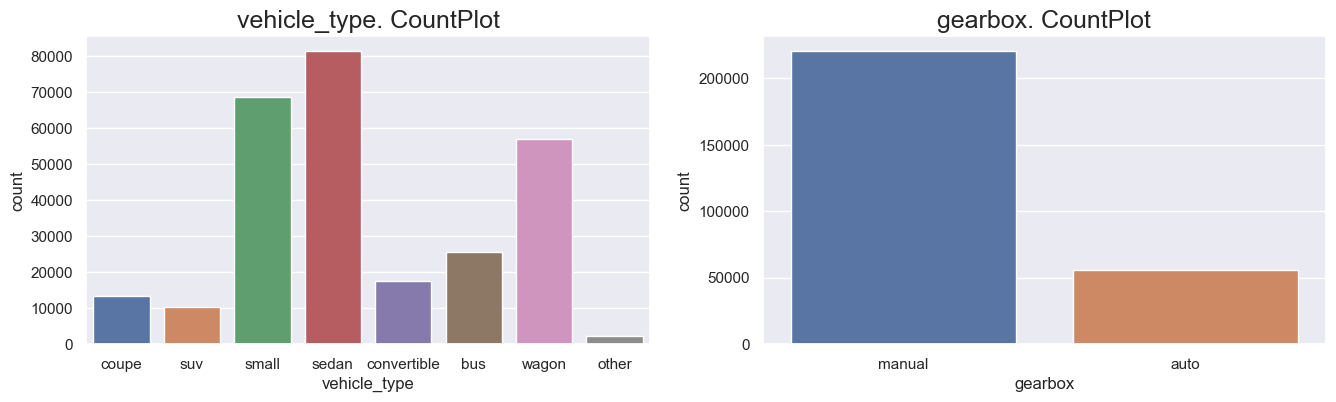

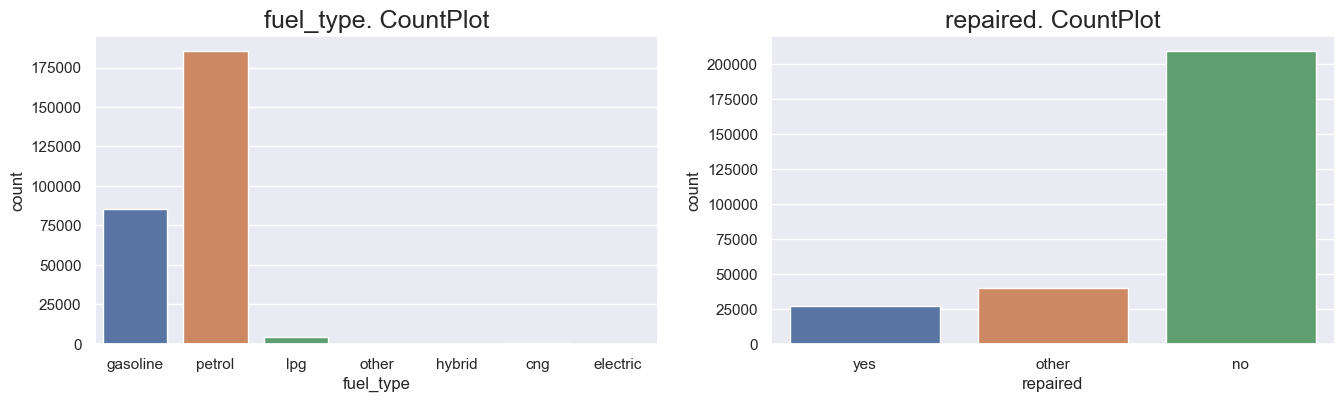

In [63]:
categoricals = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
for i in range(len(categoricals)//2):
    show_hists(df, categoricals[2*i], categoricals[2*i+1])

Посмотрим как цена на машины изменялись по годам

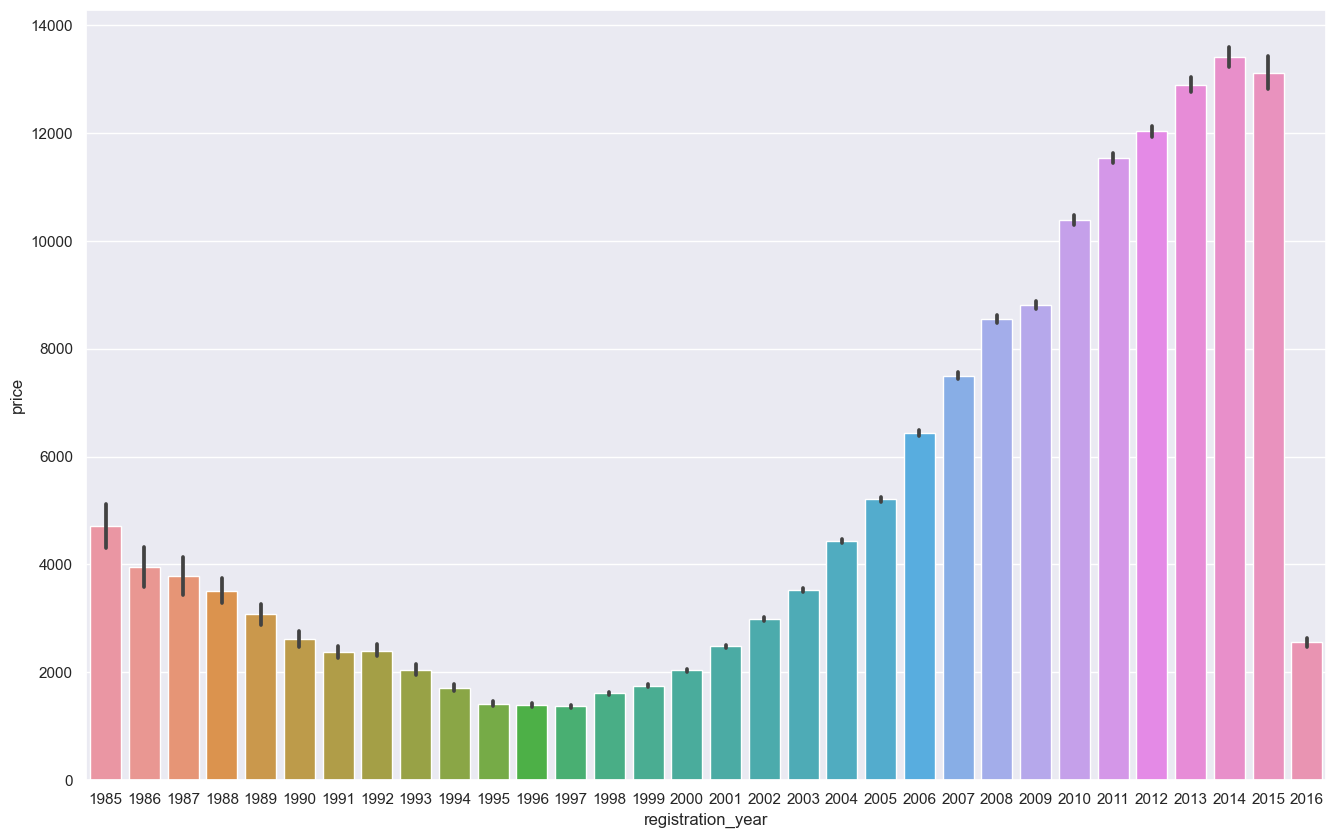

In [64]:
plt.figure(figsize=(16,10))
sns.barplot(data=df, x='registration_year', y='price');

Составим новый признак **type** в котором будут названия разных категорий машин в зависимости от их года регистрации
* *ретро* - машины до 1990 
* *старые* - машины от 1991 года по 2001
* *новые* - машины от 2002 года по 2011
* *самые-новые* - машины от 2011 года по 2016

In [65]:
df.loc[df['registration_year']<=1990, 'type'] = 'retro'
df.loc[(1991<=df['registration_year']) & (df['registration_year']<2001), 'type'] = 'old'
df.loc[(2001<=df['registration_year']) & (df['registration_year']<2011), 'type'] = 'new'
df.loc[df['registration_year']>=2011, 'type'] = 'new-new'

### Избавимся от ненужных для машинного обучения данных

In [66]:
df = df.drop(['date_crawled', 'date_created', 'postal_code', 'last_seen'], axis=1).reset_index(drop=True)

Мы избавились от ненужных для машинного обучения данных, они мешали бы давать моделям более точные предсказания

### Вывод по предобработке 
* Мы переименовали столбцы, чтобы они были написаны в стиле *snake_case*
* Удалили явные и неявные дубликаты
    * 4 явных дубликатов
    * 17350 неявных дубликатов
* Изменили типы данных
    * **date_crawled**:          object -> datetime
    * **price**:                  int64 -> uint16
    * **registration_year**:      int64 -> uint16
    * **power**:                  int64 -> uint16
    * **kilometer**:              int64 -> uint32
    * **registration_month**:     int64 -> uint8
    * **date_created**:          object -> datetime
    * **number_of_pictures**:     int64 -> uint8
    * **postal_code**:            int64 -> uint32
    * **last_seen**:             object -> datetime
* Избавились от пропусков:
    * **model** - заменили пропуски на *unknown*
    * **vehicle_type** - восстановили по признакам **model**, **brand**
    * **gearbox** - восстановили по признакам **model**, **brand**, **vehicle_type**
    * **fuel_type** - восстановили по признакам **model**, **brand**, **vehicle_type**
    * **repaired** - заменили пропуски на *unknown*
* Разобрались с выбросами
    * **price** - убрали данные о машинах которые стоят меньше 100 евро
    * **registration_year** - оставили все значения, что не лежат в диапазоне с 1985 по 2016 
    * **power** - оставили все значения, что не лежать в диапазоне с 10 по 1200 л.с.
    * **registration_month** - заметили, что в данных есть ошибка и в общем у нас получается 13 месяцев
    * **number_of_pictures** - удалили столбец number_of_pictures, так как все данные в нем равны нулю

## Подготовка данных

Посмотрим на матрицу корреляции *phik*

In [67]:
phik_overview = df.phik_matrix(interval_cols=['price', 'registration_year',
                                              'power', 'kilometer',
                                              'registration_month'])
phik_overview.round(2);

Посмотрим на нашу матрицу

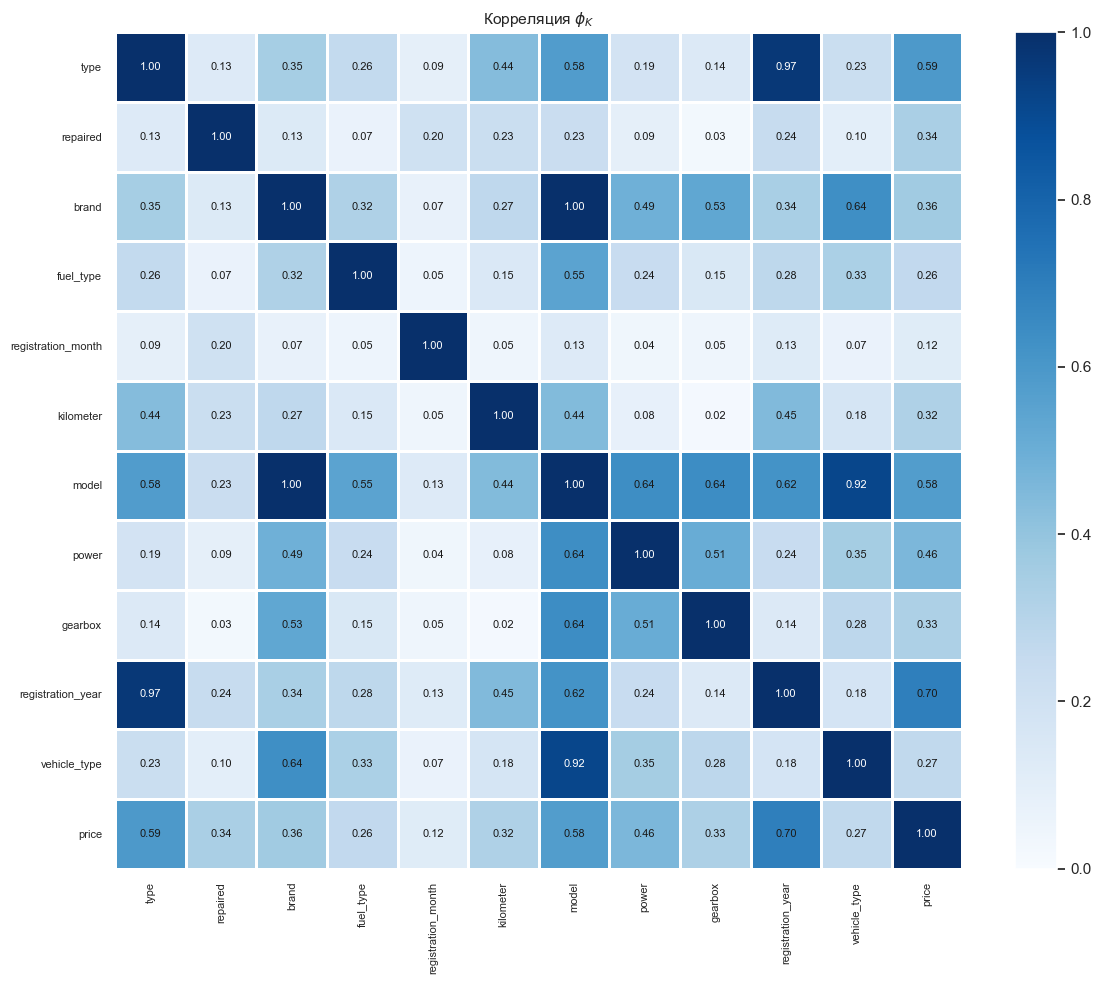

In [68]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=0.8, 
                        figsize=(12, 10))
plt.show()

Разделим данные на целевой признак и признаки:

In [69]:
features = df.drop('price', axis=1)
target = df['price']

Разделим данные на обучающию и тестовые выборки

In [70]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target,
    test_size=0.4,
    random_state=RANDOM_STATE)

Разделим тестовые данные на валидационную и тестовую выборки

In [71]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test,
    test_size=0.5,
    random_state=RANDOM_STATE)

Проверим количество данных 

In [72]:
print('features_train:',features_train.shape[0])
print('target_train:',target_train.shape[0])
print()
print('features_valid:',features_valid.shape[0])
print('target_valid:',target_valid.shape[0])
print()
print('features_test:',features_test.shape[0])
print('target_test:',target_test.shape[0])

features_train: 165774
target_train: 165774

features_valid: 55258
target_valid: 55258

features_test: 55259
target_test: 55259


Создадим трансформеры для деревянных и линейных моделей

In [73]:
num = ['registration_year', 'power', 'kilometer', 'registration_month']
categorical = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'type']
col_transformer_for_tree = make_column_transformer( 
    ( 
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        categorical
    ), 
    ( 
        StandardScaler(), 
        num
    ), 
    verbose_feature_names_out=False 
)

col_transformer_lin = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        categorical
    ),
    (
        StandardScaler(),
        num
    ),
    remainder='passthrough',
    verbose_feature_names_out=False,
)


#### Напишем функцию RMSE:

In [74]:
def RMSE(predict, target):
    return (mean_squared_error(predict, target)) ** 0.5
rmse = make_scorer(RMSE, greater_is_better=False)

#### Вывод по подготовке данных:
* Разбили данные на признаки и целевой признак
* Закодировали категориальные признаки
* Разделили данные на обучающую и тестовые выборки

## Обучение моделей

### Модель LinearRegression

Создадим конвеер из трансформера и модели, линейной регрессии 

In [75]:
pipeline_lin = Pipeline([('transformer', col_transformer_lin),
                         ('reg', LinearRegression())])

Обучим модель

In [76]:
%%time
pipeline_lin.fit(features_train, target_train)

CPU times: user 6.88 s, sys: 1.95 s, total: 8.82 s
Wall time: 3.46 s


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'type']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month'])],
                                   verbose_feature_names_out=False)),
                ('reg', LinearRegression())])

Получим предсказания нашей модели и посмотрим RMSE

In [77]:
%%time
predict = pipeline_lin.predict(features_valid)

CPU times: user 304 ms, sys: 104 ms, total: 408 ms
Wall time: 140 ms


Посмотрим на RMSE

In [78]:
RMSE(predict, target_valid)

2446.1093524567023

Создадим таблицу в которые будем заносить модели

In [79]:
df_total = pd.DataFrame.from_dict({'Модель': ['LinearRegression'],
                         'Время обучения':[8.82],
                         'Время предсказания': [0.408],
                         'RMSE': [2446]})

### Модель DecisionTreeRegressor

Создадим модель DecisionTreeRegressor для которой GridSearchCV подбирет лучшие параметры

In [80]:
params = [{'reg__random_state': [RANDOM_STATE],
          'reg__min_samples_split': range(2,4),
          'reg__min_samples_leaf': range(12,20),
          'reg__max_depth':range(13,17,1)
         }]
model_dtr = DecisionTreeRegressor() 
pipeline_dtr = Pipeline([('transformer', col_transformer_for_tree),
                     ('reg', model_dtr)])
gscv_dtr = GridSearchCV(pipeline_dtr, params, scoring=rmse, verbose=1, cv=3)
gscv_dtr.fit(features_train, target_train)

print('Лучшее значение метрики:', round(gscv_dtr.best_score_, 3) * -1,'\n')
print('Подобранные гиперпараметры модели')
gscv_dtr.best_params_

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Лучшее значение метрики: 1802.897 

Подобранные гиперпараметры модели


{'reg__max_depth': 16,
 'reg__min_samples_leaf': 13,
 'reg__min_samples_split': 2,
 'reg__random_state': 333}

Создадим лучшую модель которую нашли на GridSearchCV

In [81]:
model_dtr = gscv_dtr.best_estimator_

Обучим нашу модель на трненировочной выборке

In [82]:
%%time
model_dtr.fit(features_train, target_train)

CPU times: user 709 ms, sys: 17.6 ms, total: 726 ms
Wall time: 729 ms


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'type']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month'])],
                                   verbose_feature_names_out=False)),
                ('reg',
                 DecisionTreeRegressor(max_depth=16, min_samples_leaf=13,
                                       random_state=333))])

Получим предсказания модели

In [83]:
%%time
predict = model_dtr.predict(features_valid)

CPU times: user 93.1 ms, sys: 10.2 ms, total: 103 ms
Wall time: 103 ms


Посмотрим на метрику RMSE

In [84]:
RMSE(predict, target_valid)

1777.3649392235072

Внесем данные в таблицу

In [85]:
df_total.loc[1] = ['DecisionTreeRegressor',0.726, 0.103, 1777]
df_total

,Модель,Время обучения,Время предсказания,RMSE
0,LinearRegression,8.820,0.408,2446
1,DecisionTreeRegressor,0.726,0.103,1777


### Модель RandomForestRegressor

Создадим модель RandomForestRegressor для которой GridSearchCV подбирет лучшие параметры

In [86]:
params = [{'reg__random_state': [RANDOM_STATE],
          'reg__n_estimators': [50, 100, 200, 500],
          'reg__min_samples_split': [2],
          'reg__min_samples_leaf': [2, 5],
          'reg__max_depth':[5, 8, 10]
         }]
model_rfr =  RandomForestRegressor() 
pipeline_rfr = Pipeline([('transformer', col_transformer_for_tree),
                     ('reg', model_rfr)])
gscv_rfr = GridSearchCV(pipeline_rfr, params, scoring=rmse, verbose=1, cv=3)
gscv_rfr.fit(features_train, target_train)

print('Лучшее значение метрики:', round(gscv_rfr.best_score_, 3) * -1,'\n')
print('Подобранные гиперпараметры модели')
gscv_rfr.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Лучшее значение метрики: 1803.868 

Подобранные гиперпараметры модели


{'reg__max_depth': 10,
 'reg__min_samples_leaf': 2,
 'reg__min_samples_split': 2,
 'reg__n_estimators': 500,
 'reg__random_state': 333}

Создадим лучшую модель которую нашли на GridSearchCV

In [87]:
model_rfr = gscv_rfr.best_estimator_

Обучим нашу модель на трненировочной выборке

In [88]:
%%time
model_rfr.fit(features_train, target_train)

CPU times: user 1min 49s, sys: 594 ms, total: 1min 49s
Wall time: 1min 50s


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'type']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month'])],
                                   verbose_feature_names_out=False)),
                ('reg',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=2,
                                       n_estimators=500, random_state=333))])

Получим предсказания модели

In [89]:
%%time
predict = model_rfr.predict(features_valid)

CPU times: user 2.39 s, sys: 36.9 ms, total: 2.43 s
Wall time: 2.46 s


Посмотрим на метрику RMSE

In [90]:
RMSE(predict, target_valid)

1822.2147474410701

Внесем данные в таблицу

In [91]:
df_total.loc[2] = ['RandomForestRegressor', 109, 2.43, 1822]
df_total

,Модель,Время обучения,Время предсказания,RMSE
0,LinearRegression,8.820,0.408,2446
1,DecisionTreeRegressor,0.726,0.103,1777
2,RandomForestRegressor,109.000,2.430,1822


### Модель CatBoostRegressor

Создадим модель CatBoostRegressor для которой GridSearchCV подбирет лучшие параметры

In [92]:
params = [{'reg__verbose': [False],
          'reg__random_state': [RANDOM_STATE],
          'reg__learning_rate': [0.05, 0.1,0.2],
          'reg__depth':range(8,11,1)
         }]
model_cbr = CatBoostRegressor() 
pipeline_cbr = Pipeline([('transformer', col_transformer_for_tree),
                     ('reg', model_cbr)])
gscv_cbr = GridSearchCV(pipeline_cbr, params, scoring=rmse, verbose=1, cv=3)
gscv_cbr.fit(features_train, target_train)

print('Лучшее значение метрики:', round(gscv_cbr.best_score_, 3) * -1,'\n')
print('Подобранные гиперпараметры модели')
gscv_cbr.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Лучшее значение метрики: 1509.422 

Подобранные гиперпараметры модели


{'reg__depth': 10,
 'reg__learning_rate': 0.1,
 'reg__random_state': 333,
 'reg__verbose': False}

Создадим лучшую модель которую нашли на GridSearchCV

In [93]:
model_cbr = gscv_cbr.best_estimator_

Обучим нашу модель

In [94]:
%%time
model_cbr.fit(features_train, target_train)

CPU times: user 1min 15s, sys: 2.99 s, total: 1min 18s
Wall time: 16.4 s


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'type']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month'])],
                                   verbose_feature_names_out=False)),
                ('reg',
                 <catboost.core.CatBoostRegressor object at 0x149d55250>)])

Сделаем предсказания на валидационной выборке

In [95]:
%%time
predict = model_cbr.predict(features_valid)

CPU times: user 591 ms, sys: 12.4 ms, total: 604 ms
Wall time: 308 ms


Подсчитаем RMSE

In [96]:
RMSE(predict, target_valid)

1503.5189071710215

Внесем данные в таблицу

In [97]:
df_total.loc[3] = ['CatBoostRegressor', 78, 0.604, 1503]
df_total

,Модель,Время обучения,Время предсказания,RMSE
0,LinearRegression,8.820,0.408,2446
1,DecisionTreeRegressor,0.726,0.103,1777
2,RandomForestRegressor,109.000,2.430,1822
3,CatBoostRegressor,78.000,0.604,1503


### Модель LGBMRegressor

Подберем лучшую модель LGBMRegressor на GridSearchCV

In [98]:
params_lgbmr = [{'reg__num_leaves':[200, 500, 750, 1000],
           'reg__learning_rate':[0.01, 0.05, 0.1, 0.3],
           'reg__random_state':[RANDOM_STATE],
           'reg__min_child_samples': [10,20,30,40]}]
model_lgbmr = LGBMRegressor() 
pipline_lgbmr = Pipeline([('transformer', col_transformer_for_tree),
                         ('reg', model_lgbmr)])

gscv_lgbmr = GridSearchCV(pipline_lgbmr, params_lgbmr, scoring=rmse, cv=3)
gscv_lgbmr.fit(features_train, target_train)

print('Лучшее значение метрики:', round(gscv_lgbmr.best_score_, 3) * -1,'\n')
print('Подобранные гиперпараметры модели')
gscv_lgbmr.best_params_

Лучшее значение метрики: 1515.482 

Подобранные гиперпараметры модели


{'reg__learning_rate': 0.1,
 'reg__min_child_samples': 10,
 'reg__num_leaves': 500,
 'reg__random_state': 333}

Создадим модель лучшую LGBMRegressor на GridSearchCV

In [99]:
model_lgbmr = gscv_lgbmr.best_estimator_

Повторно обучим модель

In [100]:
%%time
model_lgbmr.fit(features_train, target_train)

CPU times: user 12 s, sys: 169 ms, total: 12.2 s
Wall time: 1.72 s


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'type']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month'])],
                                   verbose_feature_names_out=False)),
                ('reg',
                 LGBMRegressor(min_child_samples=10, num_leaves=500,
                               random_state=333))])

Найдем предсказания модели

In [101]:
%%time
predict = model_lgbmr.predict(features_valid)

CPU times: user 1.62 s, sys: 57.2 ms, total: 1.68 s
Wall time: 246 ms


Посмотрим какой RMSE получился у нашей модели

In [102]:
RMSE(predict, target_valid)

1499.1375854237117

Занесем данные в таблицу

In [103]:
df_total.loc[4] = ['LGBMRegressor', 12.2, 1.68, 1499]
df_total.sort_values(by=['RMSE', 'Время предсказания']).reset_index(drop=True)

,Модель,Время обучения,Время предсказания,RMSE
0,LGBMRegressor,12.200,1.680,1499
1,CatBoostRegressor,78.000,0.604,1503
2,DecisionTreeRegressor,0.726,0.103,1777
3,RandomForestRegressor,109.000,2.430,1822
4,LinearRegression,8.820,0.408,2446


Так как в нашей задаче требуется более быстрое время предсказания и точность то стоит выбрать модель CatBoostRegressor

## Анализ лучшей модели

Инициализируем модель

In [104]:
best_model = model_cbr

Дополним обучающую выборку валидационной 

In [105]:
features_train = pd.concat([features_train, features_valid], ignore_index=True)
target_train = pd.concat([target_train, target_valid], ignore_index=True)

Обучим на новой тренеровочной выборке

In [106]:
best_model.fit(features_train, target_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'type']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month'])],
                                   verbose_feature_names_out=False)),
                ('reg',
                 <catboost.core.CatBoostRegressor object at 0x149d55250>)])

Получим предсказание модели

In [107]:
%%time
predict = best_model.predict(features_test)

CPU times: user 486 ms, sys: 15.7 ms, total: 502 ms
Wall time: 288 ms


Посмотрим на RMSE

In [108]:
RMSE(predict, target_test)

1467.4106393990853

Как мы видим наша модель сделала предсказание за пол секунды, а её RMSE = 1467

Посмотрим на важность признаков для нашей модели

In [109]:
pivot_table = pd.DataFrame({'name': best_model[:-1].get_feature_names_out(),
    'score': best_model.named_steps['reg'].get_feature_importance()})
pivot_table.sort_values(by='score', ascending=False).reset_index(drop=True)

,name,score
0,registration_year,30.973879
1,power,22.394760
2,brand,11.420114
3,kilometer,8.410053
4,vehicle_type,7.224043
5,type,5.629178
6,model,5.289549
7,repaired,2.889304
8,fuel_type,2.643559
9,registration_month,1.696546


Как мы видим нет ненужных признаков, самыми значимами для модели признаками оказались
* registration_year - 26.9
* power - 23
* brand - 12.1
* kilometer - 9.1
* vehicle_type - 7.5

## Вывод
* Знакомство с данными
    * Мы загрузили нужные нам библиотеки и данные
    * Сохранили данные в датафрейм **df**
    * Выяснили, что:
        * Нужно привести столбцы к стилю snake_case
        * В наших данных есть пропущенные значен
        * Все значения в столбце NumberOfPictures принимают нулевые значения
        * Нужно изменить типы данных в таблице и удалить не нужные колонки
        * В данных присутствуют 4 явных дубликата
* Предоброботка
    * Мы переименовали столбцы, чтобы они были написаны в стиле *snake_case*
    * Удалили явные и неявные дубликаты
        * 4 явных дубликатов
        * 17350 неявных дубликатов
    * Изменили типы данных
        * **date_crawled**:          object -> datetime
        * **price**:                  int64 -> uint16
        * **registration_year**:      int64 -> uint16
        * **power**:                  int64 -> uint16
        * **kilometer**:              int64 -> uint32
        * **registration_month**:     int64 -> uint8
        * **date_created**:          object -> datetime
        * **number_of_pictures**:     int64 -> uint8
        * **postal_code**:            int64 -> uint32
        * **last_seen**:             object -> datetime
    * Избавились от пропусков:
        * **model** - заменили пропуски на *unknown*
        * **vehicle_type** - восстановили по признакам **model**, **brand**
        * **gearbox** - восстановили по признакам **model**, **brand**, **vehicle_type**
        * **fuel_type** - восстановили по признакам **model**, **brand**, **vehicle_type**
        * **repaired** - заменили пропуски на *unknown*
    * Разобрались с выбросами
        * **price** - убрали данные о машинах которые стоят меньше 100 евро
        * **registration_year** - оставили все значения, что не лежать в диапазоне с 1985 по 2023
        * **power** - оставили все значения, что не лежать в диапазоне с 10 по 1200 л.с.
        * **registration_month** - заметили, что в данных есть ошибка и в общем у нас получается 13 месяцев
        * **number_of_pictures** - удалили столбец number_of_pictures, так как все данные в нем равны нулю
* подготовке данных:
    * Разбили данные на признаки и целевой признак
    * Закодировали категориальные признаки
    * Разделили данные на обучающую и тестовые выборки
* Обучение моделей
    * Мы нашли лучшие параметры и обучили 5 моделей:
        * LinearRegression
        * CatBoostRegressor
        * LGBMRegressor 
        * DecisionTreeRegressor
        * RandomForestRegressor     
    * Самой лучшей моделью в данной задаче я считаю CatBoostRegressor так как она делает максимально точные предсказания за минимальное время, мы проверили ее на тестовой выборке и получили такие результаты
        * Время предсказания: 0.5 s
        * RMSE: 1467
        * Самыми значимами для модели признаками оказались
            * registration_year - 26.9
            * power - 23
            * brand - 12.1
            * kilometer - 9.1
            * vehicle_type - 7.5
            